# Imports

In [191]:
import pandas as pd
import numpy as np
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import string, re

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 300
# help with layout
plt.rcParams.update({'figure.autolayout': True})


In [177]:
df = pd.read_csv('../data/reddit_dominion.csv')

In [178]:
df.head()

,title,id,created_utc,year,month,full_link,body_len,word_count,char_count,has_media,num_comments,commments_greater
0,Travel solutions for dominion for bringing it to friends places,q6vqiv,1634072881,2021,10,https://www.reddit.com/r/dominion/comments/q6vqiv/travel_solutions_for_dominion_for_bringing_it_to/,808,10,63,0,7,0
1,"I made a visual reskin for Dominion, what do you think?",q6sq9p,1634064029,2021,10,https://www.reddit.com/r/dominion/comments/q6sq9p/i_made_a_visual_reskin_for_dominion_what_do_you/,1786,11,55,0,18,1
2,Hot take re rule change: Players should be able to choose between a 3/4 or 5/2 treasure start,q6r219,1634059104,2021,10,https://www.reddit.com/r/dominion/comments/q6r219/hot_take_re_rule_change_players_should_be_able_to/,786,18,93,0,49,1
3,when will we get previews for the new expansion?,q6p8h4,1634053988,2021,10,https://www.reddit.com/r/dominion/comments/q6p8h4/when_will_we_get_previews_for_the_new_expansion/,541,9,48,0,11,1
4,An analysis on Fisherman,q60zp3,1633973345,2021,10,https://www.reddit.com/r/dominion/comments/q60zp3/an_analysis_on_fisherman/,7389,4,24,0,5,0


In [179]:
df.shape

(7121, 12)

In [180]:
df.sort_values(by = ['created_utc'], inplace = True)

In [181]:
df.head()

,title,id,created_utc,year,month,full_link,body_len,word_count,char_count,has_media,num_comments,commments_greater
7105,"Dominion Deck Builder | Share, discuss and rate Dominion card combinations",en9hw,1292565223,2010,12,https://www.reddit.com/r/dominion/comments/en9hw/dominion_deck_builder_share_discuss_and_rate/,0,11,74,0,0,0
7106,Dominion: Cornucopia announced. Theme: Variety.,f2gt5,1295040872,2011,1,https://www.reddit.com/r/dominion/comments/f2gt5/dominion_cornucopia_announced_theme_variety/,0,5,47,0,1,0
7109,Online Dominion,fe1r5,1296680348,2011,2,https://www.reddit.com/r/dominion/comments/fe1r5/online_dominion/,0,2,15,0,3,0
7108,Looking for someone to play a multiple rounds,fj3la,1297381276,2011,2,https://www.reddit.com/r/dominion/comments/fj3la/looking_for_someone_to_play_a_multiple_rounds/,274,8,45,0,6,0
7107,The Secret History of the Dominion Cards (written by Donald X himself!),fw55j,1299108955,2011,3,https://www.reddit.com/r/dominion/comments/fw55j/the_secret_history_of_the_dominion_cards_written/,0,12,71,0,0,0


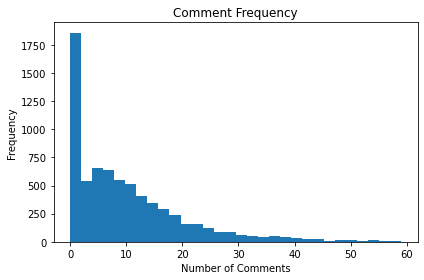

In [190]:
plt.hist(df[df['num_comments']<60]['num_comments'], bins = 30)
plt.title('Comment Frequency')
plt.xlabel('Number of Comments')
plt.ylabel('Frequency')

plt.show()

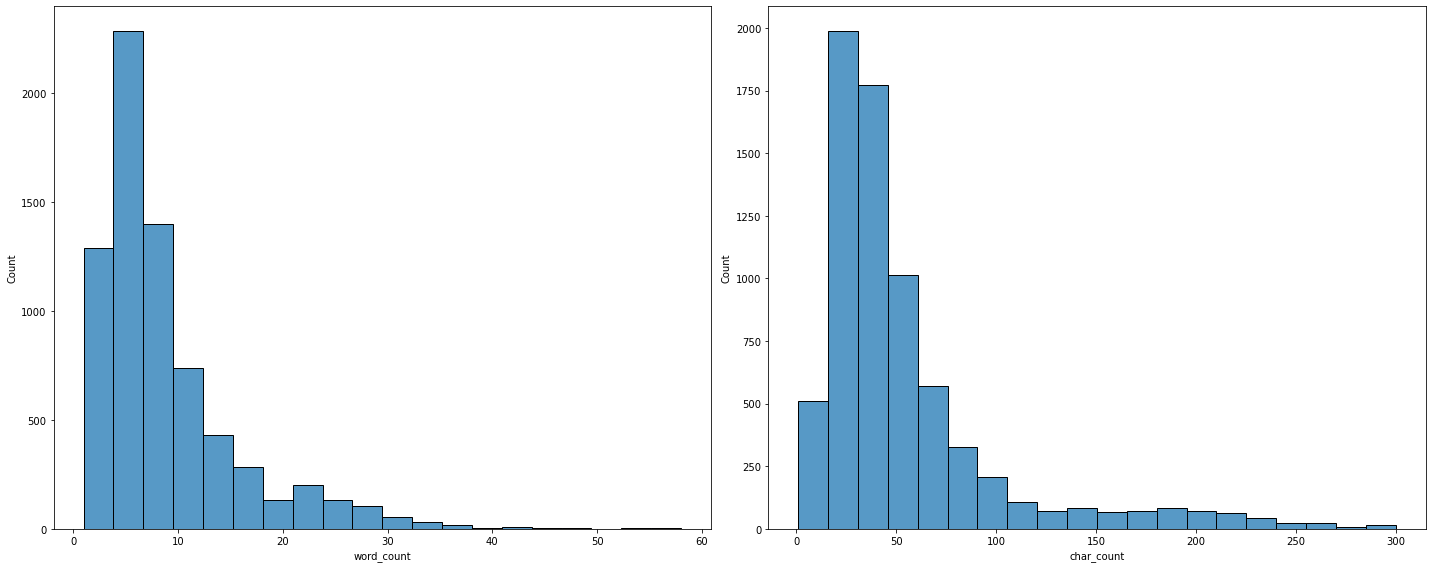

In [182]:
fig, ax = plt.subplots(1,2, figsize = (20,8))
sns.histplot(df['word_count'], ax=ax[0], bins = 20);
sns.histplot(df['char_count'], ax = ax[1], bins = 20);

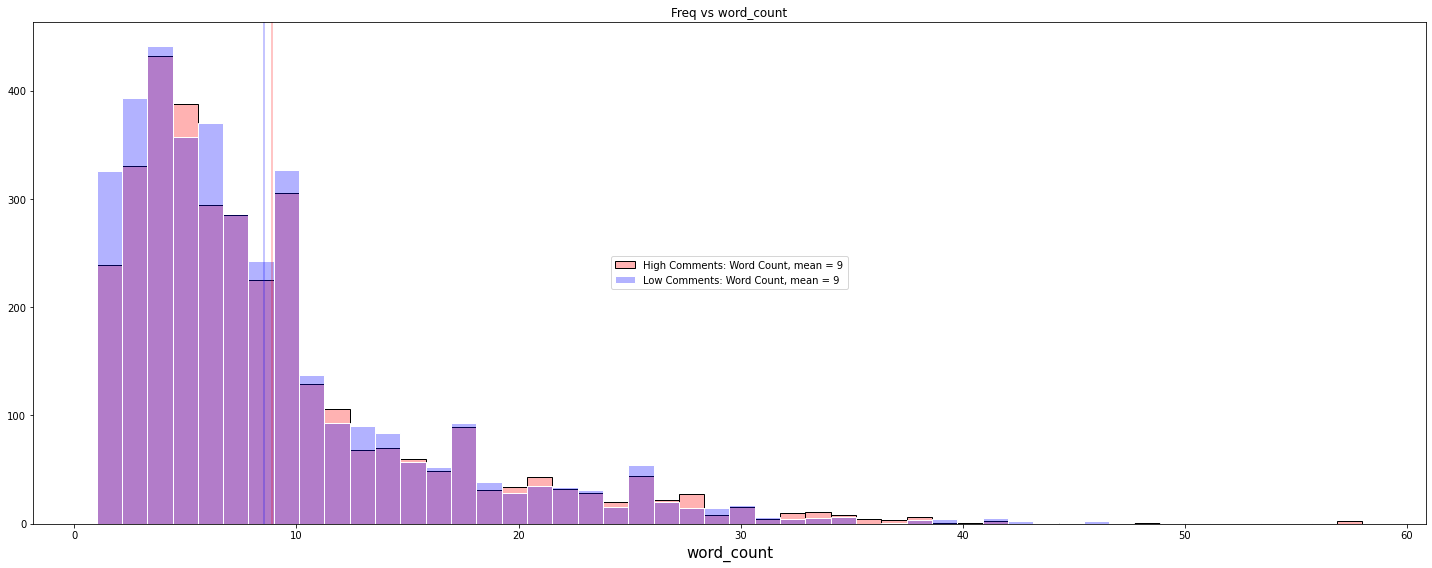

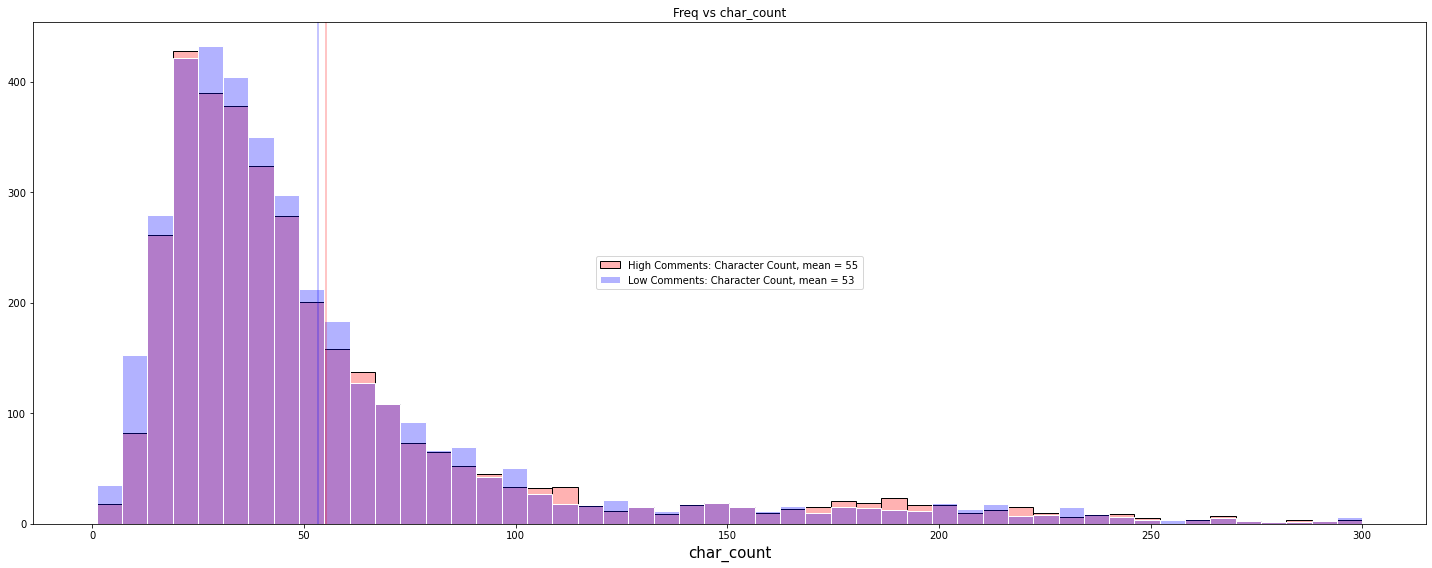

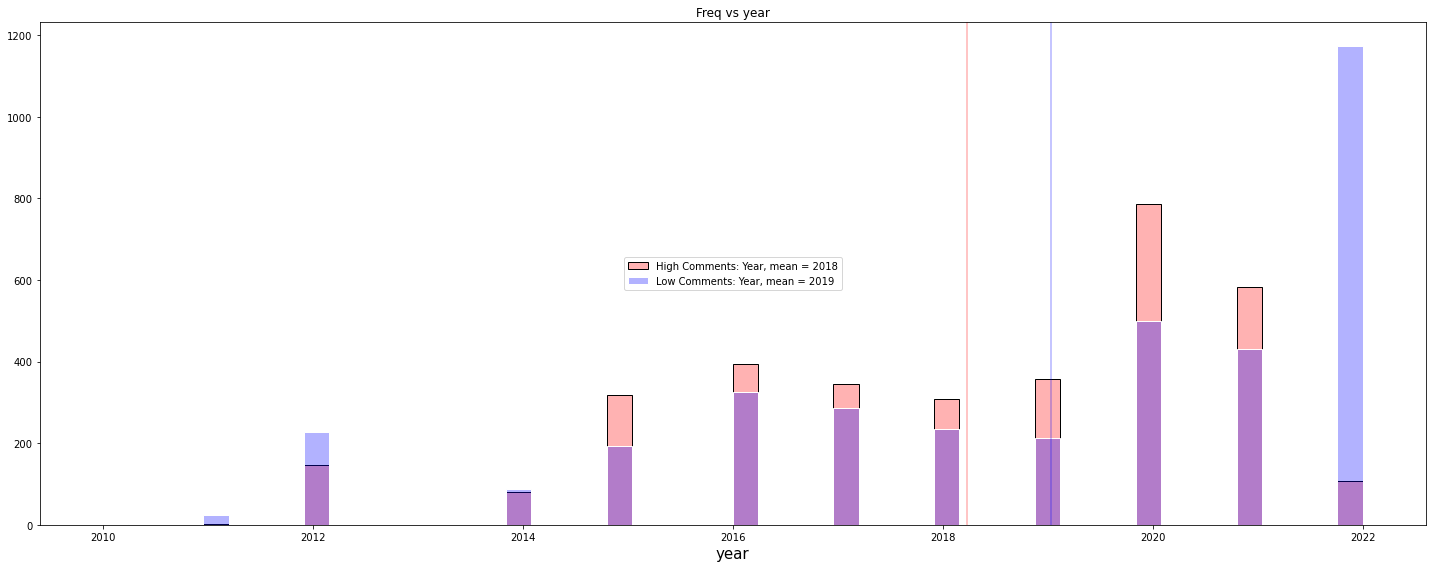

In [189]:
features = ['word_count', 'char_count', 'year']
labels = ['Word Count', 'Character Count', 'Year']
color1 = (1,0,0,0.3)
color2 = (0,0,1,0.3)
target = df['commments_greater']
for i in range(len(features)):
    fig, ax = plt.subplots(figsize = (20,8))
    feature = features[i]
    bins = np.histogram(df[feature], bins=50)[1]
    lab = labels[i]
    avg_high_comments = df[target==1][feature].mean()
    avg_low_comments = df[target == 0][feature].mean()
    ax.hist(df[target==1][feature], bins = bins, label = f'High Comments: {lab}, mean = {round(avg_high_comments)}', color = color1,edgecolor='k');
    ax.hist(df[target==0][feature], bins = bins, label = f'Low Comments: {lab}, mean = {round(avg_low_comments)}', color = color2, edgecolor='w');
    ax.axvline(avg_high_comments, color = color1)
    ax.axvline(avg_low_comments, color = color2)

    ax.set_xlabel(f'{feature}', size=15)
    ax.set(title = f'Freq vs {feature}')
    ax.legend(loc='center');

# TO DO: Create a few more plots comparing parameters to number of comments
## Make plots comparing high frequency words with viral and non viral posts

# Examining Popular Words

In [160]:
def lemma_tokenizer(doc):
    wnl = WordNetLemmatizer()
    tokens = word_tokenize(doc)
    return [wnl.lemmatize(t) for t in tokens]

def stemmer_tokenizer(doc):
    ps = PorterStemmer()
    tokens = word_tokenize(doc)
    tokens = [ps.stem(re.sub(r"[^a-zA-Z0-9 ]", "", t)) for t in tokens if t not in stops and t not in string.punctuation] #other languages
    tokens = [re.sub(r'\W+', ' ', t) for t in tokens if t not in stops and t not in string.punctuation] #strange characters
    tokens = [re.sub('\d+', '', t) for t in tokens if t not in stops and t not in string.punctuation ] #numerical
    return [ps.stem(re.sub("\\W",'',t)) for t in tokens if t not in stops and t not in string.punctuation]
stops = set(stopwords.words('english'))


cv = CountVectorizer(stop_words=stops, min_df=3, tokenizer=stemmer_tokenizer)

cv.fit(df['title'])
words_df = pd.DataFrame(cv.transform(df['title']).A, columns = cv.get_feature_names_out())
print(f'shape of words df = {words_df.shape}')
words_df.head()

/Users/andrewfalcone/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/andrewfalcone/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'nt', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


shape of words df = (7121, 1836)


,abil,abl,absolut,abu,academi,access,accid,accompani,account,achiev,...,ya,yall,ye,yeah,year,yesterday,yet,young,youtub,ypsilanti
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [161]:
words_df.shape

(7121, 1836)

In [162]:
df.shape

(7121, 15)

In [163]:
df2 = pd.concat([df.reset_index(drop=True), words_df.reset_index(drop=True)], axis=1)

In [164]:
df2.head()

,title,created_utc,full_link,num_comments,id,body_len,has_media,GMT_time,year,month,...,ya,yall,ye,yeah,year,yesterday,yet,young,youtub,ypsilanti
0,"Dominion Deck Builder | Share, discuss and rate Dominion card combinations",1292565223,https://www.reddit.com/r/dominion/comments/en9hw/dominion_deck_builder_share_discuss_and_rate/,0,en9hw,0,False,2010-12-17 05:53:43+00:00,2010,12,...,0,0,0,0,0,0,0,0,0,0
1,Dominion: Cornucopia announced. Theme: Variety.,1295040872,https://www.reddit.com/r/dominion/comments/f2gt5/dominion_cornucopia_announced_theme_variety/,1,f2gt5,0,False,2011-01-14 21:34:32+00:00,2011,01,...,0,0,0,0,0,0,0,0,0,0
2,Online Dominion,1296680348,https://www.reddit.com/r/dominion/comments/fe1r5/online_dominion/,3,fe1r5,0,False,2011-02-02 20:59:08+00:00,2011,02,...,0,0,0,0,0,0,0,0,0,0
3,Looking for someone to play a multiple rounds,1297381276,https://www.reddit.com/r/dominion/comments/fj3la/looking_for_someone_to_play_a_multiple_rounds/,6,fj3la,274,False,2011-02-10 23:41:16+00:00,2011,02,...,0,0,0,0,0,0,0,0,0,0
4,The Secret History of the Dominion Cards (written by Donald X himself!),1299108955,https://www.reddit.com/r/dominion/comments/fw55j/the_secret_history_of_the_dominion_cards_written/,0,fw55j,0,False,2011-03-02 23:35:55+00:00,2011,03,...,0,0,0,0,0,0,0,0,0,0


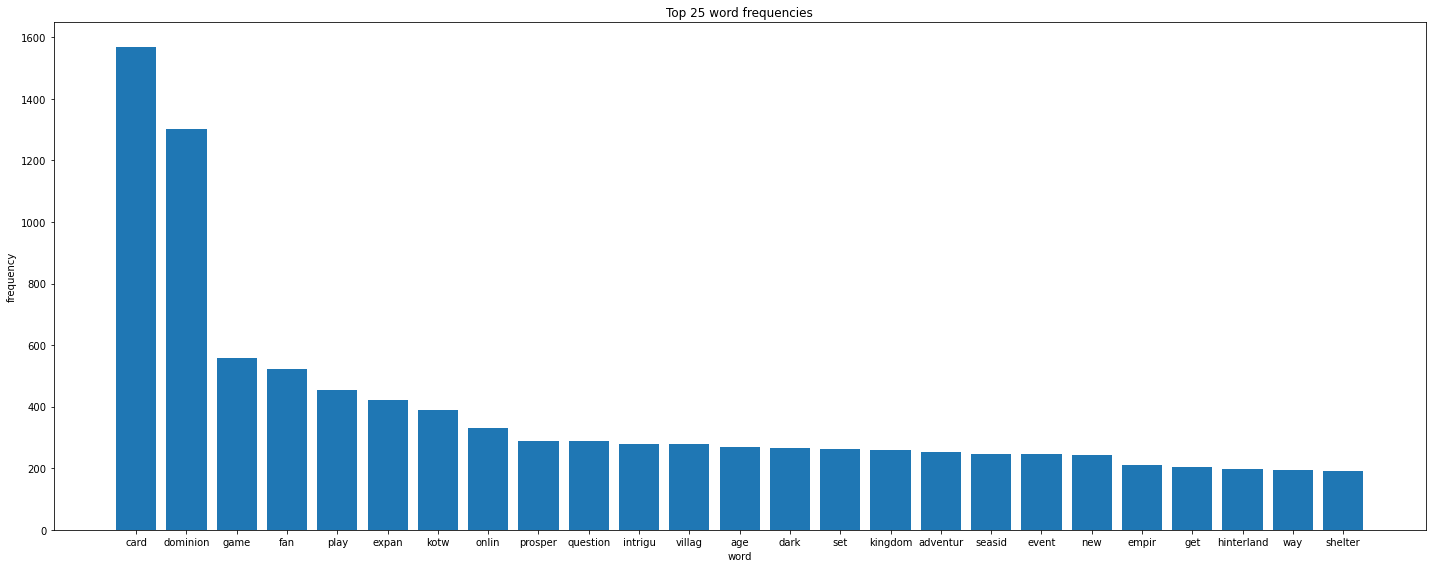

In [165]:

fig, ax = plt.subplots(figsize = (20,8))
ax.bar(x=words_df.sum().sort_values(ascending=False)[:top_k].index, height=words_df.sum().sort_values(ascending=False)[:top_k]);
ax.set(title = f'Top {top_k} word frequencies', xlabel = 'word', ylabel = 'frequency')
plt.show()

In [166]:
# excluding stopwords
cv_bigrams = CountVectorizer(ngram_range=(1,3), stop_words='english')
cv_bigrams.fit(df['title'])
X_train_bigrams = cv_bigrams.transform(df['title'])
pd.DataFrame(X_train_bigrams.A, columns=cv_bigrams.get_feature_names_out()).sum().sort_values(ascending = False)[:10]


dominion      1416
card           902
cards          683
fan            529
game           453
kotw           386
fan card       376
online         333
intrigue       293
prosperity     293
dtype: int64